In [34]:
! pip install tldextract


In [35]:
import numpy as np
import pandas as pd
import ipaddress as ip
from os.path import splitext
from urllib.parse import urlparse
from tqdm.notebook import tqdm
import tldextract

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

load the data and change the label format to bool type

In [36]:
train_df = pd.read_csv("/notebooks/security-engineering3/train_url.csv")
test_df = pd.read_csv("/notebooks/security-engineering3/test_url.csv")

y_train = np.array(train_df['Label'])
y_train = np.where(y_train=='bad',"0", np.where(y_train=='good', "1", y_train))
y_test = np.array(test_df['Label'])
y_test = np.where(y_test=='bad',"0", np.where(y_test=='good', "1", y_test))

In [37]:
def delPath(url):
    if ',' in url:
        url = url.split(',')[0]
    url = url.strip()
    if url.startswith('http://') or url.startswith('https://'):
        pass
    else:
        url = 'http://' + url
    try:
        parse = urlparse.urlparse(url)
        url_new = parse.scheme + '://' + parse.netloc
    except:
        url_new = url
    if url_new.endswith('.'):
        url_new = url_new.rstrip('.')
    return url_new
for i in tqdm(range(len(test_df))):
    test_df['URL'][i] = delPath(test_df['URL'][i])
for i in tqdm(range(len(train_df))):
    train_df['URL'][i] = delPath(train_df['URL'][i])

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/40000 [00:00<?, ?it/s]

In [38]:
test_df.head()

,URL,Label
0,http://grandmaous.com/docx/index.php,bad
1,http://prettynicewebsite.com/746t3fg3,bad
2,http://'www.leisureideas.com/logic\%20puzzles....,good
3,http://mediabistro.com/galleycat/carlo-deste-w...,good
4,http://sunjournal.com/funeral-services/story/1...,good


## Feature engineering

In [39]:
def countdots(url):  
    return url.count('.')

def countdelim(url):
    count = 0
    delim=[';','_','?','=','&']
    for each in url:
        if each in delim:
            count = count + 1  
    return count

def isip(url):
    try:
        if ip.ip_address(url):
            return 1
    except:
        return 0
    
def isPresentHyphen(url):
    return url.count('-')

def isPresentAt(url):
    return url.count('@')

def isPresentUnderscore(url):
    return url.count('_')

def isPresentDSlash(url):
    return url.count('//')

def countSubDir(url):
    return url.count('/')

def get_ext(url):
    root, ext = splitext(url)
    return ext

def countSubDomain(subdomain):
    if not subdomain:
        return 0
    else:
        return len(subdomain.split('.'))
    
def countQueries(query):
    if not query:
        return 0
    else:
        return len(query.split('&'))

In [40]:
train_set = pd.DataFrame(columns=('url','no of dots','presence of hyphen','len of url','presence of at', \
'presence of double slash','no of subdir','no of subdomain','len of domain','no of queries','is IP'))

test_set = pd.DataFrame(columns=('url','no of dots','presence of hyphen','len of url','presence of at', \
'presence of double slash','no of subdir','no of subdomain','len of domain','no of queries','is IP'))

In [41]:
def getFeatures(url, label): 
    result = []
    url = str(url)
    
    # add the url to feature set
    result.append(url)
    
    # parse the URL and extract the domain information
    try:
        path = urlparse(url)
        ext = tldextract.extract(url)
    except ValueError as e:
        pass


    
    # counting number of dots in subdomain    
    result.append(countdots(url))
    
    # checking hyphen in domain   
    result.append(isPresentHyphen(path.netloc))
    
    # length of URL    
    result.append(len(url))
    
    # checking @ in the url    
    result.append(isPresentAt(url))
    
    # checking _ in the url
    #result.append(isPresentUnderscore(path.path))
    
    # checking presence of double slash    
    result.append(isPresentDSlash(path.path))
    
    # Count number of subdir    
    result.append(countSubDir(path.path))
    
    # number of sub domain    
    result.append(countSubDomain(ext.subdomain))
    
    # length of domain name    
    result.append(len(path.netloc))
    
    # count number of queries    
    result.append(len(path.query))
    
    # Adding domain information
    
    # if IP address is being used as a URL     
    result.append(isip(ext.domain))
    
    return result

In [42]:
for i in tqdm(range(len(train_df))):
    train_set.loc[i] = getFeatures(train_df["URL"].loc[i], train_df["Label"].loc[i])

  0%|          | 0/40000 [00:00<?, ?it/s]

In [43]:
for i in tqdm(range(len(test_df))):
    try:
        test_set.loc[i] = getFeatures(test_df["URL"].loc[i], test_df["Label"].loc[i])
    except UnboundLocalError as e:
        print(str(test_df["URL"].loc[i]))
        test_set.loc[i] = getFeatures('http://facebook.com/martin.paul', test_df["Label"].loc[i])

  0%|          | 0/10000 [00:00<?, ?it/s]

http://ÆeF§÷%¶¿Õ½9¿b@Ö¸ÚZE¤ÒC¢ÄÅª2åç-]W³fU¤Jgkz.ø¿nJçåæuøD%@ðûÇùM¹uË


In [44]:
train_set.head()

,url,no of dots,presence of hyphen,len of url,presence of at,presence of double slash,no of subdir,no of subdomain,len of domain,no of queries,is IP
0,http://facebook.com/martin.paul,2,0,31,0,0,1,0,12,0,0
1,http://mikworks.com/originalwork/footballers/,1,0,45,0,0,3,0,12,0,0
2,http://upi.com/Top_News/US/2010/12/19/Transbay...,1,0,89,0,0,8,0,7,0,0
3,http://evri.com/person/thomas-dagworth-0x9f71d,1,0,46,0,0,2,0,8,0,0
4,http://eastbay.citysearch.com/profile/1033557/...,3,0,80,0,0,4,1,22,0,0


In [45]:
test_set.head()

,url,no of dots,presence of hyphen,len of url,presence of at,presence of double slash,no of subdir,no of subdomain,len of domain,no of queries,is IP
0,http://grandmaous.com/docx/index.php,2,0,36,0,0,2,0,14,0,0
1,http://prettynicewebsite.com/746t3fg3,1,0,37,0,0,1,0,21,0,0
2,http://'www.leisureideas.com/logic\%20puzzles....,3,0,50,0,0,1,1,21,0,0
3,http://mediabistro.com/galleycat/carlo-deste-w...,1,0,151,0,0,2,0,15,0,0
4,http://sunjournal.com/funeral-services/story/1...,1,0,52,0,0,3,0,14,0,0


## Statistic

### IP address appears in domain
The number of IP address appearing in domain field where URLs are normal

In [46]:
train_set[y_train=="1"]['is IP'].value_counts()

0    27978
1        2
Name: is IP, dtype: int64

The number of IP address appearing in domain field where URLs are malicious

In [47]:
train_set[y_train=="0"]['is IP'].value_counts()

0    11417
1      603
Name: is IP, dtype: int64

### The ”@” symbol in the URL

The number of "@" appearing in domain field where URLs are normal

In [48]:
train_set[y_train=="1"]['presence of at'].value_counts()

0    27966
1       13
6        1
Name: presence of at, dtype: int64

The number of "@" appearing in domain field where URLs are malicious

In [49]:
train_set[y_train=="0"]['presence of at'].value_counts()

0    11870
1      146
3        2
2        2
Name: presence of at, dtype: int64

In [50]:
train_set[y_train=="1"]['presence of double slash'].value_counts()

0    27979
1        1
Name: presence of double slash, dtype: int64

In [51]:
train_set[y_train=="0"]['presence of double slash'].value_counts()

0    11957
1       61
2        2
Name: presence of double slash, dtype: int64

In [52]:
train_set[y_train=="0"]['presence of hyphen'].value_counts()

0     10432
1      1120
2       179
4       170
3        64
5        19
6        14
11        6
7         5
8         4
9         3
10        2
14        1
12        1
Name: presence of hyphen, dtype: int64

In [53]:
train_set[y_train=="1"]['presence of hyphen'].value_counts()

0    26537
1     1203
2      193
3       38
5        4
4        4
8        1
Name: presence of hyphen, dtype: int64

## Visualization of some features

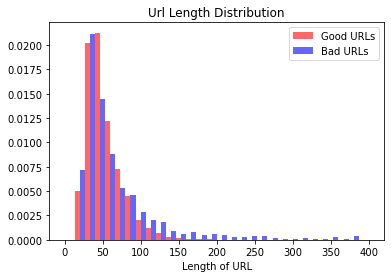

In [54]:
a = train_set[y_train=="1"]['len of url']
b = train_set[y_train=="0"]['len of url']
plt.hist([a,b],color=['red','blue'],alpha=0.6,label=['Good URLs','Bad URLs'],bins=30,density=True,range=(0,400),rwidth=1)
plt.title('Url Length Distribution')
plt.legend(loc='upper right')
plt.xlabel('Length of URL')
plt.show()

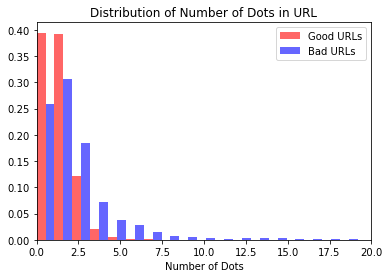

In [55]:
a = train_set[y_train=="1"]['no of dots']
b = train_set[y_train=="0"]['no of dots']
plt.hist([a,b],color=['red','blue'],alpha=0.6,label=['Good URLs','Bad URLs'],bins=30,density=True,rwidth=1)
plt.legend(loc='upper right')
plt.xlabel('Number of Dots')
plt.title('Distribution of Number of Dots in URL')
plt.xlim(0,20)
plt.show()

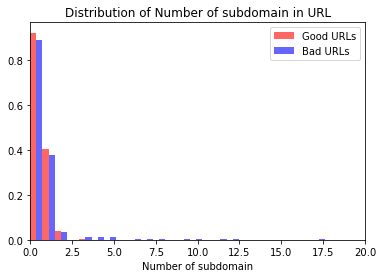

In [56]:
a = train_set[y_train=="1"]['no of subdomain']
b = train_set[y_train=="0"]['no of subdomain']
plt.hist([a,b],color=['red','blue'],alpha=0.6,label=['Good URLs','Bad URLs'],bins=30,density=True,rwidth=1)
plt.legend(loc='upper right')
plt.xlabel('Number of subdomain')
plt.title('Distribution of Number of subdomain in URL')
plt.xlim(0,20)
plt.show()

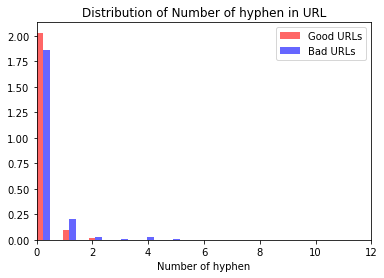

In [57]:
a = train_set[y_train=="1"]['presence of hyphen']
b = train_set[y_train=="0"]['presence of hyphen']
plt.hist([a,b],color=['red','blue'],alpha=0.6,label=['Good URLs','Bad URLs'],bins=30,density=True,rwidth=1)
plt.legend(loc='upper right')
plt.xlabel('Number of hyphen')
plt.title('Distribution of Number of hyphen in URL')
plt.xlim(0,12)
plt.show()

## Train and test

In [58]:
import sklearn.ensemble as ensemble
from sklearn import tree, linear_model
from sklearn.feature_selection import SelectFromModel
import joblib
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn import svm
from sklearn.linear_model import LogisticRegression

In [59]:
x_train = train_set.drop(['url'],axis=1).values
x_test = test_set.drop(['url'],axis=1).values

In [60]:
AdaBoost = ensemble.AdaBoostClassifier(n_estimators=50)
AdaBoost.fit(x_train, y_train)
score = AdaBoost.score(x_test, y_test)
print ("The AdaBoost score is :", score)

The AdaBoost score is : 0.7843


In [61]:
DecisionTree = tree.DecisionTreeClassifier(max_depth=10)
DecisionTree.fit(x_train, y_train)
score = DecisionTree.score(x_test, y_test)
print ("The Decision Tree score is :", score)

The Decision Tree score is : 0.7909


In [62]:
RandomForest = ensemble.RandomForestClassifier(n_estimators=50)
RandomForest.fit(x_train, y_train)
score = RandomForest.score(x_test, y_test)
print ("The RandomForest score is :", score)

The RandomForest score is : 0.8382


Text(0.5, 15.0, 'Predicted Class')

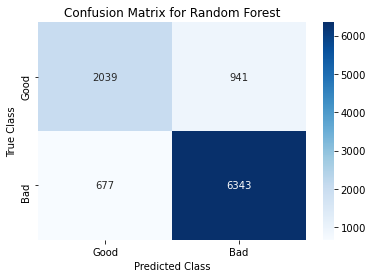

In [71]:
from sklearn.metrics import confusion_matrix
y_pred = RandomForest.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
labels = ['Good', 'Bad']
sns.heatmap(cm, xticklabels=labels, yticklabels=labels, annot=True, fmt="d", cmap='Blues')
plt.title("Confusion Matrix for Random Forest" )
plt.ylabel('True Class')
plt.xlabel('Predicted Class')

In [74]:
tn, fp, fn, tp = cm.ravel()
print(tn,fp,fn,tp)

2039 941 677 6343


In [77]:
#TPR = TP/(TP+FN)
#FPR = FP/(FP+TN)

TPR = tp/(tp+fn);
FPR = fp/(fp+tn);

print("True Positive Rate is:", TPR)
print("False Positive Rate is:",FPR)

True Positive Rate is: 0.9035612535612536
False Positive Rate is: 0.3157718120805369
